In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import lightgbm as lgb
import catboost as cb
from keras.wrappers.scikit_learn import KerasRegressor
from keras import Sequential
from keras.layers import Dense

from tsfresh.examples import load_robot_execution_failures
from tsfresh import extract_features, select_features
import optuna

from common import EP
from models import *
from dfdb import DFDB

import types
import os
import copy

import seaborn as sns
import matplotlib.pyplot as plt

# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
# os.environ["CUDA_VISIBLE_DEVICES"]="3";  

Using TensorFlow backend.


In [2]:
pd.set_option('display.max_colwidth', -1)

In [3]:
%%HTML
<style>
   div#notebook-container    { width: 95%; }
   div#menubar-container     { width: 65%; }
   div#maintoolbar-container { width: 99%; }
</style>

In [4]:
pd.set_option('display.max_columns', 2000)
pd.set_option('display.max_rows', 2000)
# pd.set_option('display.width', 2000)
# pd.set_option('display.expand_frame_repr', True)
pd.set_option('display.max_colwidth', -1)

In [5]:
def m_lineplot(dflist, plot_features=None, n_col=3):

    
    n_chart = len(dflist)
    n_row = int(n_chart/n_col) if n_chart % n_col == 0 else n_row+1
        
    fig = plt.figure(figsize=(5*n_col, 3*n_row))
    for i, df in enumerate(dflist):
        ax = fig.add_subplot(n_row, n_col, i+1)
        if type(plot_features) == type(None):
            plot_features = df.columns.tolist()
        for feat in plot_features:
            sns.lineplot(x=df.index, y=df[feat], ax=ax)
    return 

In [6]:
df_train = pd.read_pickle('../feats/df_train.pkl')
df_test = pd.read_pickle('../feats/df_test.pkl')

In [7]:
df_train['label'] = df_train['y'].apply(lambda x:  int(x) if x<15 else 15)
group = df_train['season'].values
group[np.where(group==17)[0]] = 1
df_train['group'] = group
df_train = df_train.drop(columns=['season'])

In [8]:
df_spec_train = pd.read_pickle('../feats/spec_features.pkl')
df_spec_test = pd.read_pickle('../feats/spec_features_test.pkl')

df_train = pd.merge(df_train, df_spec_train, on='index')
df_test = pd.merge(df_test, df_spec_test, on='index')

In [9]:
test_X = df_train.drop(columns=['y','index','group','label']).copy()
test_X.index = df_train['index']
test_y = df_train['y'].copy()
test_y.index = df_train['index']
tsfresh_columns = select_features(test_X, test_y).columns.tolist()

In [10]:
catboost_columns = ['mfcc_3_rolling_std_mean',
  'max_9',
  'q25_roll_std_100',
  'max_to_min',
  'max_to_min_5',
  'iqr_6',
  'q05_roll_std_1000',
  'q05_roll_std_100',
  'abs_max_4',
  'abs_max_1',
  'spkt_welch_densitycoeff_2',
  'spkt_welch_density__coeff_3',
  'abs_q75_7',
  'q01_2',
  'abs_q01_4',
  'max_to_min_diff_5',
  'q05_5',
  'abs_q25_5',
  'abs_max_2',
  'min__roll_std',
  'median__roll_std',
  'abs_max_7',
  '5000peak_peak_amp_max_',
  'abs_q75_6']
lgbm_columns = ['mfcc_10_abs_q75',
  'q25_roll_std_100',
  'iqr_6',
  'mfcc_9_mean',
  'abs_q75_7',
  'mfcc_delta_5_min',
  'mfcc_delta_3_quantile01',
  'abs_q75_6',
  'q05_roll_std_100',
  'mfcc_accelerate_1_kurtosis',
  'mfcc_5_mean',
  'spkt_welch_density__coeff_42',
  'mfcc_3_rolling_std_mean',
  'mfcc_12_mean',
  '5000smoothness_entropy_',
  'mfcc_13_mean',
  "change_quantiles{'ql': 0.2, 'qh': 0.8, 'isabs': False, 'f_agg': 'var'}",
  'mfcc_5_abs_max',
  'abs_q25_5',
  'mfcc_5_quantile95',
  'spkt_welch_densitycoeff_5',
  '5000crest_factor_quantile75',
  'spkt_welch_densitycoeff_2',
  'mfcc_accelerate_8_variance',
  "number_peaks{'n': 10}",
  'spkt_welch_density__coeff_3']
xgbm_columns = ['q05_roll_std_1000',
  'q05_roll_std_100',
  'mfcc_9_mean',
  'abs_q01_4',
  'iqr_6',
  'spkt_welch_density__coeff_4',
  'abs_q25_5',
  'abs_q75_6',
  'q01_2',
  "change_quantiles{'ql': 0.2, 'qh': 0.8, 'isabs': False, 'f_agg': 'var'}",
  'abs_max_4',
  'median__roll_std',
  'abs_max_7',
  'spkt_welch_density__coeff_28',
  '5000crest_factor_quantile75',
  'mfcc_1_kurtosis',
  'mfcc_4_median',
  'q05_5',
  'abs_max_8',
  'abs_q75_7',
  'q25_roll_std_100',
  'mfcc_delta_3_quantile01',
  'spkt_welch_densitycoeff_2',
  'max_to_min_diff_5',
  'mfcc_12_mean',
  'spkt_welch_densitycoeff_5',
  'spkt_welch_density__coeff_3',
  "number_peaks{'n': 10}",
  'spkt_welch_density__coeff_27']

In [12]:
all_columns = catboost_columns+lgbm_columns+xgbm_columns
unique_columns = list(set(all_columns))
common_columns = []
common_columns50 = []
common_columns75 = []
common_columns95 = []
N_columns = 6
count_values = [all_columns.count(col) for col in unique_columns]
for col in unique_columns:
    if all_columns.count(col)==N_columns:
        common_columns.append(col)
    if all_columns.count(col)>=np.quantile(count_values, .5):
        common_columns50.append(col)
    if all_columns.count(col)>=np.quantile(count_values, .75):
        common_columns75.append(col)
    if all_columns.count(col)>=np.quantile(count_values, .95):
        common_columns95.append(col)
print('unique_columns ',len(unique_columns))
print('common_columns50 ',len(common_columns50))
print('common_columns75 ',len(common_columns75))
print('common_columns95 ',len(common_columns95))
print('common_columns ',len(common_columns))

unique_columns  47
common_columns50  24
common_columns75  24
common_columns95  8
common_columns  0


In [18]:
db = DFDB('../trial/kerasmlp.pkl', auto_commit=False)
df_trial = db.select()
df_trial['kfold-type'] = df_trial['param'].apply(lambda x: x['kfold']['type'])
df_trial['algorithm-init'] = df_trial['param'].apply(lambda x: x['algorithm']['init'])

In [18]:
df_trial[['datetime','nfeatures', 'kfold-type', 'algorithm-init', 'train_mae','train_mae_var','val_mae','val_mae_var','mae_diff', 'remark']].loc[[13]]

,datetime,nfeatures,kfold-type,algorithm-init,train_mae,train_mae_var,val_mae,val_mae_var,mae_diff,remark
13,2019-05-17 18:50:09.056814,30,stratified,"{'batch': 128, 'solver': 'adam', 'metric': 'mean_absolute_error', 'lr': 0.0001, 'sgd_momentum': 0.9, 'sgd_decay': 0.0001, 'base_save_dir': 'KerasMLPRegressor/input_dim=30,hidden_layer_sizes=[128, 16],activation='relu',l1l2regularizer=None,dropout=0.3', 'alias': 'kerasmlp', 'input_dim': 30, 'hidden_layer_sizes': [128, 16], 'activation': 'relu', 'l1l2regularizer': None, 'dropout': 0.3}",1.87789,0.000123,1.91037,0.000008,0.032479,None


In [13]:
param13 = {'algorithm': {'cls': 'KerasMLPRegressor',
  'fit': {'versbose': 0, 'epochs': 20, 'eval_set':True},
  'init': {'batch': 128,
   'solver': 'adam',
   'metric': 'mean_absolute_error',
   'lr': 0.0001,
   'sgd_momentum': 0.9,
   'sgd_decay': 0.0001,
   'base_save_dir': "KerasMLPRegressor",
   'alias': 'kerasmlp',
   'input_dim': len(common_columns50),
   'hidden_layer_sizes': [128, 16],
   'activation': 'relu',
   'l1l2regularizer': None,
   'dropout': 0.3}},
 'columns': common_columns50,
 'kfold': {'n_splits': 3,
  'random_state': 1985,
  'shuffle': True,
  'type': 'group'},
 'scaler': {'cls': 'StandardScaler', 'init':{}}}

In [14]:
def width_frist_rfe(df_train, param, trial, score, df_test=None, remark=None):

    param_ = copy.deepcopy(param)
    columns_ = param_['columns']
    best_score = score
    best_param = param_
    for col in columns_:
        param_['columns'] = list(set(columns_) - set([col]))
        param_['algorithm']['init']['input_dim'] = len(param_['columns'])
        df_his, df_feature_importances, df_valid_pred, df_test_pred = EP.process(df_train, param_, df_test=df_test, trial=trial, is_output_feature_importance=False, remark=remark)
        val_mae_mean = np.mean(df_his.valid)
        if val_mae_mean<best_score:
            best_score = val_mae_mean
            best_param = copy.deepcopy(param_)

    if best_score < score:
        width_frist_rfe(df_train, best_param, trial, best_score, df_test, remark=remark)

    return

In [15]:
mytrial = []
width_frist_rfe(df_train, param13, mytrial, 9999, df_test, remark='tune 13 with new features')

KeyboardInterrupt: 

In [17]:
len(mytrial)

80

In [19]:
for trial_i in mytrial:
    db.insert(trial_i)
df_trial = db.select()
df_trial['kfold-type'] = df_trial['param'].apply(lambda x: x['kfold']['type'])
df_trial['algorithm-init'] = df_trial['param'].apply(lambda x: x['algorithm']['init'])

In [21]:
df_trial[df_trial['remark']=='tune 13 with new features'][['datetime','nfeatures', 'kfold-type', 'algorithm-init', 'train_mae','train_mae_var','val_mae','val_mae_var','mae_diff']].sort_values(by=['val_mae'])

,datetime,nfeatures,kfold-type,algorithm-init,train_mae,train_mae_var,val_mae,val_mae_var,mae_diff
191,2019-06-02 05:16:30.937538,44,group,"{'batch': 128, 'solver': 'adam', 'metric': 'mean_absolute_error', 'lr': 0.0001, 'sgd_momentum': 0.9, 'sgd_decay': 0.0001, 'base_save_dir': 'KerasMLPRegressor', 'alias': 'kerasmlp', 'input_dim': 44, 'hidden_layer_sizes': [128, 16], 'activation': 'relu', 'l1l2regularizer': None, 'dropout': 0.3}",1.917082,0.000870,2.051699,0.011182,0.134617
174,2019-06-02 00:34:39.652938,45,group,"{'batch': 128, 'solver': 'adam', 'metric': 'mean_absolute_error', 'lr': 0.0001, 'sgd_momentum': 0.9, 'sgd_decay': 0.0001, 'base_save_dir': 'KerasMLPRegressor', 'alias': 'kerasmlp', 'input_dim': 45, 'hidden_layer_sizes': [128, 16], 'activation': 'relu', 'l1l2regularizer': None, 'dropout': 0.3}",1.923036,0.000632,2.054622,0.011269,0.131587
264,2019-06-03 04:22:36.005023,21,group,"{'batch': 128, 'solver': 'adam', 'metric': 'mean_absolute_error', 'lr': 0.0001, 'sgd_momentum': 0.9, 'sgd_decay': 0.0001, 'base_save_dir': 'KerasMLPRegressor', 'alias': 'kerasmlp', 'input_dim': 21, 'hidden_layer_sizes': [128, 16], 'activation': 'relu', 'l1l2regularizer': None, 'dropout': 0.3}",1.980297,0.003090,2.061363,0.013425,0.081065
252,2019-06-03 01:56:23.912433,22,group,"{'batch': 128, 'solver': 'adam', 'metric': 'mean_absolute_error', 'lr': 0.0001, 'sgd_momentum': 0.9, 'sgd_decay': 0.0001, 'base_save_dir': 'KerasMLPRegressor', 'alias': 'kerasmlp', 'input_dim': 22, 'hidden_layer_sizes': [128, 16], 'activation': 'relu', 'l1l2regularizer': None, 'dropout': 0.3}",1.977448,0.002766,2.061852,0.013693,0.084404
168,2019-06-01 23:11:28.719494,45,group,"{'batch': 128, 'solver': 'adam', 'metric': 'mean_absolute_error', 'lr': 0.0001, 'sgd_momentum': 0.9, 'sgd_decay': 0.0001, 'base_save_dir': 'KerasMLPRegressor', 'alias': 'kerasmlp', 'input_dim': 45, 'hidden_layer_sizes': [128, 16], 'activation': 'relu', 'l1l2regularizer': None, 'dropout': 0.3}",1.933202,0.002275,2.062467,0.010901,0.129265
112,2019-06-01 11:05:31.780677,46,group,"{'batch': 128, 'solver': 'adam', 'metric': 'mean_absolute_error', 'lr': 0.0001, 'sgd_momentum': 0.9, 'sgd_decay': 0.0001, 'base_save_dir': 'KerasMLPRegressor', 'alias': 'kerasmlp', 'input_dim': 46, 'hidden_layer_sizes': [128, 16], 'activation': 'relu', 'l1l2regularizer': None, 'dropout': 0.3}",1.912609,0.001449,2.062871,0.009869,0.150262
134,2019-06-01 15:04:12.681108,46,group,"{'batch': 128, 'solver': 'adam', 'metric': 'mean_absolute_error', 'lr': 0.0001, 'sgd_momentum': 0.9, 'sgd_decay': 0.0001, 'base_save_dir': 'KerasMLPRegressor', 'alias': 'kerasmlp', 'input_dim': 46, 'hidden_layer_sizes': [128, 16], 'activation': 'relu', 'l1l2regularizer': None, 'dropout': 0.3}",1.917317,0.001283,2.063427,0.011011,0.146110
198,2019-06-02 07:45:02.930081,44,group,"{'batch': 128, 'solver': 'adam', 'metric': 'mean_absolute_error', 'lr': 0.0001, 'sgd_momentum': 0.9, 'sgd_decay': 0.0001, 'base_save_dir': 'KerasMLPRegressor', 'alias': 'kerasmlp', 'input_dim': 44, 'hidden_layer_sizes': [128, 16], 'activation': 'relu', 'l1l2regularizer': None, 'dropout': 0.3}",1.924776,0.001263,2.064059,0.010120,0.139283
189,2019-06-02 04:42:16.936291,44,group,"{'batch': 128, 'solver': 'adam', 'metric': 'mean_absolute_error', 'lr': 0.0001, 'sgd_momentum': 0.9, 'sgd_decay': 0.0001, 'base_save_dir': 'KerasMLPRegressor', 'alias': 'kerasmlp', 'input_dim': 44, 'hidden_layer_sizes': [128, 16], 'activation': 'relu', 'l1l2regularizer': None, 'dropout': 0.3}",1.924819,0.001568,2.064547,0.010764,0.139728
113,2019-06-01 11:14:35.229164,46,group,"{'batch': 128, 'solver': 'adam', 'metric': 'mean_absolute_error', 'lr': 0.0001, 'sgd_momentum': 0.9, 'sgd_decay': 0.0001, 'base_save_dir': 'KerasMLPRegressor', 'alias': 'kerasmlp', 'input_dim': 46, 'hidden_layer_sizes': [128, 16], 'activation': 'relu', 'l1l2regularizer': None, 'dropout': 0.3}",1.925390,0.000618,2.064687,0.010878,0.139297


In [26]:
param = {'algorithm': {'cls': 'KerasMLPRegressor',
  'fit': {'versbose': 0, 'epochs': 20, 'eval_set': True},
  'init': {'batch': 128,
   'solver': 'adam',
   'metric': 'mean_absolute_error',
   'lr': 0.0001,
   'sgd_momentum': 0.9,
   'sgd_decay': 0.0001,
   'base_save_dir': 'KerasMLPRegressor',
   'alias': 'kerasmlp',
   'input_dim': 21,
   'hidden_layer_sizes': [128, 16],
   'activation': 'relu',
   'l1l2regularizer': None,
   'dropout': 0.3}},
 'columns': ['abs_q01_4',
  'mfcc_delta_3_quantile01',
  'spkt_welch_densitycoeff_2',
  '5000crest_factor_quantile75',
  'q05_5',
  'mfcc_3_rolling_std_mean',
  'q05_roll_std_1000',
  'q05_roll_std_100',
  'abs_q25_5',
  'median__roll_std',
  "change_quantiles{'ql': 0.2, 'qh': 0.8, 'isabs': False, 'f_agg': 'var'}",
  'abs_q75_7',
  'mfcc_9_mean',
  'q25_roll_std_100',
  'q01_2',
  'abs_max_7',
  'spkt_welch_densitycoeff_5',
  'max_to_min_diff_5',
  'abs_max_4',
  "number_peaks{'n': 10}",
  'spkt_welch_density__coeff_3'],
 'kfold': {'n_splits': 3,
  'random_state': 1985,
  'shuffle': True,
  'type': 'stratified'},
 'scaler': {'cls': 'StandardScaler', 'init': {}}}

In [27]:
mytrial=[]
df_his, df_feature_importances, df_valid_pred, df_test_pred = EP.process(df_train, param, df_test=df_test, trial=mytrial, is_output_feature_importance=False, remark='remodel 264')

In [29]:
for trial_i in mytrial:
    db.insert(trial_i)
df_trial = db.select()
df_trial['kfold-type'] = df_trial['param'].apply(lambda x: x['kfold']['type'])
df_trial['algorithm-init'] = df_trial['param'].apply(lambda x: x['algorithm']['init'])

In [30]:
db.commit()

In [31]:
df_trial[df_trial['remark']=='remodel 264'][['datetime','nfeatures', 'kfold-type', 'algorithm-init', 'train_mae','train_mae_var','val_mae','val_mae_var','mae_diff']].sort_values(by=['val_mae'])

,datetime,nfeatures,kfold-type,algorithm-init,train_mae,train_mae_var,val_mae,val_mae_var,mae_diff
291,2019-06-03 09:46:10.596763,21,stratified,"{'batch': 128, 'solver': 'adam', 'metric': 'mean_absolute_error', 'lr': 0.0001, 'sgd_momentum': 0.9, 'sgd_decay': 0.0001, 'base_save_dir': 'KerasMLPRegressor', 'alias': 'kerasmlp', 'input_dim': 21, 'hidden_layer_sizes': [128, 16], 'activation': 'relu', 'l1l2regularizer': None, 'dropout': 0.3}",2.004,0.000305,2.013895,0.000055,0.009895


In [67]:
df_his_list = [pd.read_csv(param['algorithm']['init']['base_save_dir'] + '/{}_{}_train_his.csv'.format(param['algorithm']['init']['alias'], i), index_col=0) for i in range(param['kfold']['n_splits'])]

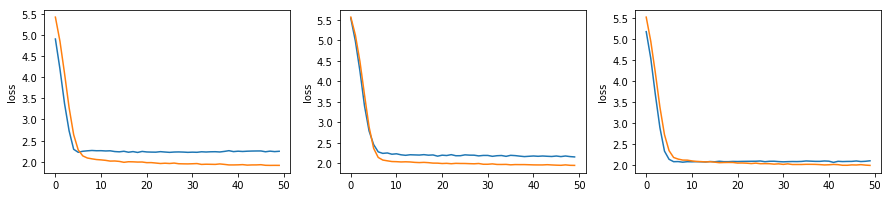

In [68]:
m_lineplot(df_his_list)

In [35]:
db.commit()